In [45]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

import pytensor.tensor.subtensor as subtensor
import arviz as az

import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing
from pytensor import grad as ptgrad
from pytensor import sparse

config.floatX = 'float64'
config.profile = True
config.profile_optimizer = True
config.profiling__n_apply = 40
config.profiling__n_ops = 40
config.exception_verbosity = 'high'

import scienceplots
# plot params
contour_levels = 10
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [46]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 300

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = -6.
x_axis_right_boundary = 6.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.02
t_end = 4.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

true_nu = 0.01
# true_nu = 1.

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

newton_tol = 0.00001

true_coordinates = mesh.p.T
n_x = len(true_coordinates)
boundary_condition = (
    (true_coordinates == x_axis_left_boundary) | (true_coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*true_coordinates).flatten()
#u_0 = np.exp((-(true_coordinates.flatten())**2)/2)
u_0true = np.exp(-((true_coordinates.flatten()-1)**2)/2) - np.exp(-((true_coordinates.flatten()+1)**2)/2) 
u_strue = np.zeros((number_of_steps, n_x))
u_strue[0,:] = u_0true

u_guess = u_0true + np.random.normal(0, 0.001, len(u_0true))
u_guess[0] = u_guess[-1] = 0

In [47]:
# Observation Parameters
true_rho = 0.01
true_ell = 3
sigma_n_true = 0.01
spatial_points = 21
temporal_points = 50

temp = np.linspace(0, len(true_coordinates) - 1, spatial_points+2, dtype=int)
spatial_measurement_indices = temp[1:-1]
spatial_measurement_coordinates = true_coordinates[spatial_measurement_indices]
temp = np.linspace(0, len(time_range) - 1, temporal_points+2, dtype=int)
temporal_measurement_indices = temp[1:-1]
temporal_measurement_coordinates = time_range[temporal_measurement_indices]

def K_theta_mat_np(rho, ell, ktheta):
    G_vec = (true_rho**2)*np.exp(ktheta/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))

K_theta_1 = np.tile(true_coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(true_coordinates, (n_x), axis=0)
K_theta = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)**2

true_K_theta_mat = K_theta_mat_np(true_rho, true_ell, K_theta)

In [48]:
endpoint_coords = np.asarray([true_coordinates.flatten()[0],true_coordinates.flatten()[-1]]).flatten().T
endpoint_vals = np.zeros(2)
endpoint_theta_1 = np.tile(endpoint_coords, 2)
endpoint_theta_2 = np.repeat(endpoint_coords, 2)
endpoint_theta = -(endpoint_theta_1 - endpoint_theta_2)**2
K_endpoint_theta = np.reshape((true_rho**2)*np.exp(endpoint_theta/(2*(true_ell**2))), (2,2))


hybrid_theta_1 = np.tile(endpoint_coords, n_x)
hybrid_theta_2 = np.repeat(true_coordinates.flatten(), 2)
hybrid_theta = -(hybrid_theta_1 - hybrid_theta_2)**2
K_hybrid_theta = np.reshape((true_rho**2)*np.exp(hybrid_theta/(2*(true_ell**2))), (n_x,2))

new_mean = K_hybrid_theta @ np.linalg.inv(K_endpoint_theta) @ endpoint_vals
new_true_K = true_K_theta_mat - K_hybrid_theta @ np.linalg.inv(K_endpoint_theta)@K_hybrid_theta.T

In [49]:
# CRANK NICHOLSON

@fem.BilinearForm
def A_build(u,v,w):
    return u*v

A_mat = A_build.assemble(basis).toarray()
# A_mat[:,0] = A_mat[:,-1] = 0.
# A_mat[0,:] = A_mat[-1,:] = 0.
A_mat[0,0] = 1e6
A_mat[-1,-1] = 1e6
# A_mat = scsparse.csr_matrix(A_mat)

@fem.BilinearForm
def B_build(u,v,w):
    return grad(u)[0]*v

B_mat = B_build.assemble(basis).toarray()
# B_mat[:,0] = B_mat[:,-1] = 0.
# B_mat[0,:] = B_mat[-1,:] = 0.
B_mat[0,0] = 1e6
B_mat[-1,-1] = 1e6
# B_mat = scsparse.csr_matrix(B_mat)

@fem.BilinearForm
def C_build(u,v,w):
    return dot(grad(u),grad(v))

C_mat = C_build.assemble(basis).toarray()
# C_mat[:,0] = C_mat[:,-1] = 0.
# C_mat[0,:] = C_mat[-1,:] = 0.
C_mat[0,0] = 1e6
C_mat[-1,-1] = 1e6
# C_mat = scsparse.csr_matrix(C_mat)

In [50]:
def residual_vector(dt, nu, u_sum, u_dif):
    return A_mat @ u_dif + (dt/4)*B_mat @ u_sum**2 + (dt*nu/2) * C_mat @ u_sum

def jacobian_matrix(dt, nu, u_sum):
    return A_mat + (dt/2)*B_mat @ u_sum + (dt*nu/2) * C_mat

nugget = 1e-5*np.eye(n_x)

for i in tqdm(range(number_of_steps-1)):
    u_previous = u_strue[i,:]
    u_guess = u_previous
    for j in range(5):
        u_sum = u_guess + u_previous
        u_dif = u_guess - u_previous
        resid = residual_vector(dt, true_nu, u_sum, u_dif)
        jacob = jacobian_matrix(dt, true_nu, u_sum) + nugget
        # jacob_sparse = scsparse.csr_matrix(jacob)
        # u_guess = u_guess + scsparse.linalg.spsolve(jacob_sparse, -resid)
        u_guess = u_guess + np.linalg.solve(jacob, -resid)
    u_strue[i+1, :] = u_guess + np.random.multivariate_normal(np.zeros(n_x), new_true_K)
    u_strue[i+1, :] = u_guess

100%|██████████| 199/199 [00:09<00:00, 22.05it/s]


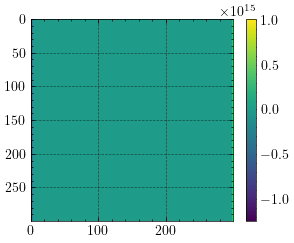

In [140]:
plt.imshow(jacob)
plt.colorbar()

In [70]:
# for i in tqdm(range(number_of_steps-1)):
#     u_strue[i+1, :] = newton_iter(dt, 0.01, u_strue[i,:])

for i in tqdm(range(number_of_steps-1)):
    u_strue[i+1, :] = get_next_sol(dt, 0.01, u_strue[i,:])

100%|██████████| 299/299 [00:18<00:00, 15.99it/s]


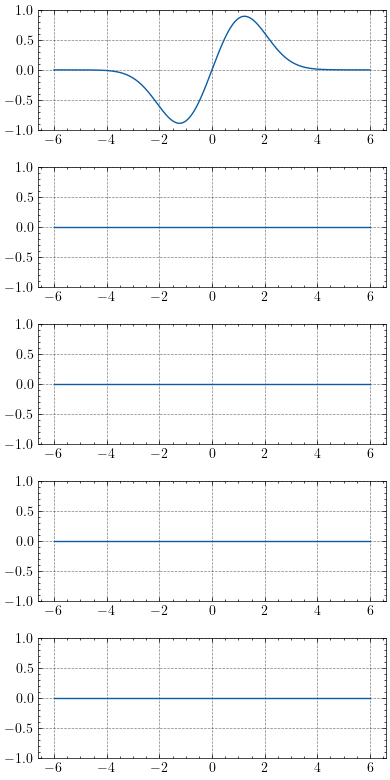

In [217]:
u_observed = u_strue[temporal_measurement_indices][:, spatial_measurement_indices] + np.random.normal(0, sigma_n_true, (temporal_points, spatial_points))

fig, axes = plt.subplots(5, 1, figsize=(4,8))
ymin = -1.
ymax = 1.
axes[0].plot(true_coordinates.flatten(),u_strue[1])
axes[0].set_ylim(ymin, ymax)
axes[1].plot(true_coordinates.flatten(),u_strue[int(np.floor(2*number_of_steps/5))])
axes[1].set_ylim(ymin, ymax)
axes[2].plot(true_coordinates.flatten(),u_strue[int(np.floor(3*number_of_steps/5))])
axes[2].set_ylim(ymin, ymax)
axes[3].plot(true_coordinates.flatten(),u_strue[int(np.floor(4*number_of_steps/5))])
axes[3].set_ylim(ymin, ymax)
axes[4].plot(true_coordinates.flatten(),u_strue[int(np.floor(5*number_of_steps/5 - 1))])
axes[4].set_ylim(ymin, ymax)
fig.tight_layout()
plt.show()

In [7]:
#number_of_x_axial_cells = 200
number_of_x_axial_cells = 300

# x_axis_left_boundary = 0.
# x_axis_right_boundary = 1.

x_axis_left_boundary = -6.
x_axis_right_boundary = 6.

x_s = np.linspace(x_axis_left_boundary, x_axis_right_boundary, number_of_x_axial_cells)

t_start = 0
dt = 0.02
t_end = 4.
time_range = np.arange(t_start, t_end, dt)
number_of_steps = len(time_range)

mesh = fem.MeshLine(x_s)
element = fem.ElementLineP1()
basis = fem.Basis(mesh, element)

newton_tol = 0.00001

coordinates = mesh.p.T
n_x = len(coordinates)
boundary_condition = (
    (coordinates == x_axis_left_boundary) | (coordinates == x_axis_right_boundary)
)
boundary_indices = np.where(boundary_condition)[0]

#u_0 = np.sin(2*np.pi*coordinates).flatten()
#u_0 = np.exp((-(coordinates.flatten())**2)/2)
u_0 = np.exp(-((coordinates.flatten()-1)**2)/2) - np.exp(-((coordinates.flatten()+1)**2)/2) 
u_s = np.zeros((number_of_steps, n_x))
u_s[0,:] = u_0

u_guess = u_0 + np.random.normal(0, 0.001, len(u_0))
u_guess[0] = u_guess[-1] = 0

covs = np.zeros((number_of_steps, n_x, n_x))

observation_operator = np.zeros((len(spatial_measurement_coordinates), len(coordinates)))
for i, y in enumerate(spatial_measurement_coordinates):
    nearest_index = np.argmin(np.abs(coordinates - y))
    observation_operator[i, nearest_index] = 1

def mark_times(all_time, mark_time):
    time_operator = np.zeros_like(all_time, dtype=bool)

    # Find the closest point in X for each element in Y
    for time in mark_time:
        closest_index = np.argmin(np.abs(all_time - time))
        time_operator[closest_index] = True
    return time_operator

time_operator = mark_times(time_range, temporal_measurement_coordinates)

In [8]:
# PRIORS ------------
# nu
# lower = 0.0001
# upper = 1.
# mu = 0.5
# sigma = 0.5
# nu_params = [lower, upper, mu, sigma]

lower = -3
upper = 10.
mu = 0.
sigma = 1.
nu_params = [lower, upper, mu, sigma]

# rho
lower = 0.0001
upper = 1.
mu = 0.5
sigma = 0.5
rho_params = [lower, upper, mu, sigma]

# ell
lower = 0.0001
upper = 3.
mu = 1.5
sigma = 1.5
ell_params = [lower, upper, mu, sigma]

# sigma_n
lower = 0.0001
upper = 0.1
mu = 0.5
sigma = 0.5
sigma_n_params = [lower, upper, mu, sigma]

# --------------



In [9]:
K_theta_1 = np.tile(coordinates, ((n_x, 1)))
K_theta_2 = np.repeat(coordinates, (n_x), axis=0)
K_theta = -np.linalg.norm(K_theta_1 - K_theta_2,axis=1)

# CRANK NICHOLSON

@fem.BilinearForm
def A_build(u,v,w):
    return u*v

A_mat = A_build.assemble(basis).toarray()
# A_mat[:,0] = A_mat[:,-1] = 0.
# A_mat[0,:] = A_mat[-1,:] = 0.
A_mat[0,0] = 1e3
A_mat[-1,-1] = 1e3
# A_mat = scsparse.csr_matrix(A_mat)

@fem.BilinearForm
def B_build(u,v,w):
    return grad(u)[0]*v

B_mat = B_build.assemble(basis).toarray()
# B_mat[:,0] = B_mat[:,-1] = 0.
# B_mat[0,:] = B_mat[-1,:] = 0.
B_mat[0,0] = 1e3
B_mat[-1,-1] = 1e3
# B_mat = scsparse.csr_matrix(B_mat)

@fem.BilinearForm
def C_build(u,v,w):
    return dot(grad(u),grad(v))

C_mat = C_build.assemble(basis).toarray()
# C_mat[:,0] = C_mat[:,-1] = 0.
# C_mat[0,:] = C_mat[-1,:] = 0.
C_mat[0,0] = 1e3
C_mat[-1,-1] = 1e3
# C_mat = scsparse.csr_matrix(C_mat)

def residual_vector(dt, nu, u_sum, u_dif):
    return A_mat @ u_dif + (dt/4)*B_mat @ u_sum**2 + (dt*nu/2) * C_mat @ u_sum

def jacobian_matrix(dt, nu, u_sum):
    return A_mat + (dt/2)*B_mat @ u_sum + (dt*nu/2) * C_mat

def K_theta_mat(rho, ell, ktheta):
    G_vec = (rho**2)*at.math.exp(ktheta/(2*(ell**2)))
    #return M_mat @ tensor.reshape(G_vec, (n_x, n_x)) @ M_mat.T
    return at.reshape(G_vec, (n_x, n_x))

def K_theta_mat_np(rho, ell, ktheta):
    G_vec = (rho**2)*np.exp(ktheta/(2*(ell**2)))
    return np.reshape(G_vec, (n_x, n_x))

covs = np.zeros((number_of_steps, n_x, n_x))
jacobs = np.zeros((number_of_steps, n_x, n_x))

In [10]:
nu = nu_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

u_previous_test = u_0true
jac_previous_test = jacob
cov_previous_test = A_mat @ K_theta_mat_np(rho, ell, K_theta) @ A_mat.T
u_observed_test = u_observed[0,:]

with pm.Model() as model:
    nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
    #nu = pm.Uniform('nu', lower=nu_params[0], upper=nu_params[1])
    rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
    ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])
    
    dt_var = shared(dt)
    A_mat_var = shared(A_mat)
    B_mat_var = shared(B_mat)
    C_mat_var = shared(C_mat)
    u_prev_var = shared(u_previous_test)
    prev_jac = shared(jac_previous_test)
    prev_cov = shared(cov_previous_test)
    H_mat = shared(observation_operator)
    u_observed_var = shared(u_observed_test)
    K_theta_var = shared(K_theta)

    resid1 = at.dot(A_mat_var, u_prev_var - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (u_prev_var + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,u_prev_var + u_prev_var)
    jacob1 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, u_prev_var + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess2 = u_prev_var + at.slinalg.solve(jacob1, -resid1)

    resid2 = at.dot(A_mat_var, guess2 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess2 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess2 + u_prev_var)
    jacob2 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess2 + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess3 = guess2 + at.slinalg.solve(jacob2, -resid2)

    resid3 = at.dot(A_mat_var, guess3 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess3 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess3 + u_prev_var)
    jacob3 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess3 + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess4 = guess3 + at.slinalg.solve(jacob3, -resid3)

    resid4 = at.dot(A_mat_var, guess4 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess4 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess4 + u_prev_var)
    jacob4 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess4 + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess5 = guess4 + at.slinalg.solve(jacob4, -resid4)

    resid5 = at.dot(A_mat_var, guess5 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess5 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess5 + u_prev_var)
    jacob5 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess5 + u_prev_var) + (dt_var * (10**nu) / 2) * C_mat_var

    guess6 = guess5 + at.slinalg.solve(jacob5, -resid5)

    inv_jacob = at.linalg.inv(jacob5)

    cov_1 = at.dot(H_mat, at.dot(inv_jacob, at.dot(prev_jac, at.dot(prev_cov, at.dot(prev_jac, at.dot(inv_jacob.T, H_mat.T))))))
    cov_2 = dt * at.add(at.dot(H_mat, at.dot(inv_jacob, at.dot(A_mat, at.dot(K_theta_mat(rho, ell, K_theta_var), at.dot(A_mat.T, at.dot(inv_jacob.T, H_mat.T)))))), (sigma_n**2)*at.eye(spatial_points))
    pred_cov = at.add(cov_1, cov_2)

    y_obs = pm.MvNormal('y_obs', mu = H_mat @ guess6, cov = pred_cov, observed = u_observed_var)

In [12]:
with model:
    trace = pm.sample(100, tune=100, var_names=['nu', 'rho', 'ell', 'sigma_n'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, rho, ell, sigma_n]


Output()

Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 1269 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
traces = []

estimate = True

nu = nu_params[2]
rho = rho_params[2]
ell = ell_params[2]
sigma_n = sigma_n_params[2]

data_index = 0

for i in tqdm(range(number_of_steps-1)):
    u_previous = u_s[i,:]
    if time_operator[i] == False:
        for j in range(5):
            u_sum = u_guess + u_previous
            u_dif = u_guess - u_previous
            resid = residual_vector(dt, 10.**nu, u_sum, u_dif)
            jacob = jacobian_matrix(dt, 10.**nu, u_sum)
            u_guess = u_guess + np.linalg.solve(jacob, -resid)
        pred_mean = u_guess
        inv_jacob = np.linalg.inv(jacob)
        cov_1 = inv_jacob @ jacobs[i, :,:] @ covs[i,:,:] @ jacobs[i,:,:].T @ inv_jacob.T
        cov_2 = dt * inv_jacob @ A_mat @ K_theta_mat_np(rho, ell, K_theta) @ A_mat.T @ inv_jacob.T
        pred_cov = cov_1 + cov_2
        covs[i+1, :, :] = pred_cov
        jacobs[i+1, :, :] = jacob
        u_s[i+1, :] = pred_mean
    else:
        if estimate == False:
            for j in range(5):
                u_sum = u_guess + u_previous
                u_dif = u_guess - u_previous
                resid = residual_vector(dt, 10.**nu, u_sum, u_dif)
                jacob = jacobian_matrix(dt, 10.**nu, u_sum)
                u_guess = u_guess + np.linalg.solve(jacob, -resid)
            pred_mean = u_guess
            cov_1 = inv_jacob @ jacobs[i,:,:] @ covs[i,:,:] @ jacobs[i,:,:].T @ inv_jacob.T
            cov_2 = dt * inv_jacob @ A_mat @ K_theta_mat_np(rho, ell, K_theta) @ A_mat.T @ inv_jacob.T
            pred_cov = cov_1 + cov_2
            S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2) * np.eye(spatial_points)
            S_n_inverse = np.linalg.inv(S_n)
            updated_mean = pred_mean + pred_cov @ observation_operator.T @ S_n_inverse @ (u_observed[data_index,:] - observation_operator @ pred_mean)
            updated_cov = pred_cov - pred_cov @ observation_operator.T @ S_n_inverse @ observation_operator @ pred_cov
            covs[i+1, :, :] = updated_cov
            jacobs[i+1, :, :] = jacob
            u_s[i+1, :] = updated_mean
            data_index += 1
        else:
            with pm.Model() as model:
                if data_index == 0:
                    nu = pm.TruncatedNormal('nu', mu=nu_params[2], sigma=nu_params[3], lower=nu_params[0], upper=nu_params[1])
                    rho = pm.TruncatedNormal('rho', mu=rho_params[2], sigma=rho_params[3], lower=rho_params[0], upper=rho_params[1])
                    ell = pm.TruncatedNormal('ell', mu=ell_params[2], sigma=ell_params[3], lower=ell_params[0], upper=ell_params[1])
                    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n_params[2], sigma=sigma_n_params[3], lower=sigma_n_params[0], upper=sigma_n_params[1])
                else:
                    nu = pm.TruncatedNormal('nu', mu=nu, sigma=nu_std, lower=nu_updated_params[0], upper=nu_updated_params[1])
                    rho = pm.TruncatedNormal('rho', mu=rho, sigma=rho_std, lower=rho_updated_params[0], upper=rho_updated_params[1])
                    ell = pm.TruncatedNormal('ell', mu=ell, sigma=ell_std, lower=ell_updated_params[0], upper=ell_updated_params[1])
                    sigma_n = pm.TruncatedNormal('sigma_n', mu=sigma_n, sigma=sigma_n_std, lower=sigma_n_updated_params[0], upper=sigma_n_updated_params[1])
                
                dt_var = shared(dt)
                A_mat_var = shared(A_mat)
                B_mat_var = shared(B_mat)
                C_mat_var = shared(C_mat)
                u_prev_var = shared(u_s[i,:])
                prev_jac = shared(jacobs[i,:,:])
                prev_cov = shared(covs[i,:,:])
                H_mat = shared(observation_operator)
                u_observed_var = shared(u_observed[data_index,:])
                K_theta_var = shared(K_theta)

                resid1 = at.dot(A_mat_var, u_prev_var - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (u_prev_var + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,u_prev_var + u_prev_var)
                jacob1 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, u_prev_var + u_prev_var) + (dt_var * (10.**nu) / 2) * C_mat_var

                guess2 = u_prev_var + at.slinalg.solve(jacob1, -resid1)

                resid2 = at.dot(A_mat_var, guess2 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess2 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess2 + u_prev_var)
                jacob2 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess2 + u_prev_var) + (dt_var * (10.**nu) / 2) * C_mat_var

                guess3 = guess2 + at.slinalg.solve(jacob2, -resid2)

                resid3 = at.dot(A_mat_var, guess3 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess3 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess3 + u_prev_var)
                jacob3 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess3 + u_prev_var) + (dt_var * (10.**nu) / 2) * C_mat_var

                guess4 = guess3 + at.slinalg.solve(jacob3, -resid3)

                resid4 = at.dot(A_mat_var, guess4 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess4 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess4 + u_prev_var)
                jacob4 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess4 + u_prev_var) + (dt_var * (10.**nu) / 2) * C_mat_var

                guess5 = guess4 + at.slinalg.solve(jacob4, -resid4)

                resid5 = at.dot(A_mat_var, guess5 - u_prev_var) + (dt_var / 4) * at.dot(B_mat_var, (guess5 + u_prev_var) ** 2) + (dt_var * (10**nu) / 2) * at.dot(C_mat_var,guess5 + u_prev_var)
                jacob5 = A_mat_var + (dt/ 2) * at.dot(B_mat_var, guess5 + u_prev_var) + (dt_var * (10.**nu) / 2) * C_mat_var

                guess6 = guess5 + at.slinalg.solve(jacob5, -resid5)

                inv_jacob = at.linalg.inv(jacob5)

                cov_1 = at.dot(H_mat, at.dot(inv_jacob, at.dot(prev_jac, at.dot(prev_cov, at.dot(prev_jac.T, at.dot(inv_jacob.T, H_mat.T))))))
                cov_2 = dt * at.add(at.dot(H_mat, at.dot(inv_jacob, at.dot(A_mat, at.dot(K_theta_mat(rho, ell, K_theta_var), at.dot(A_mat.T, at.dot(inv_jacob.T, H_mat.T)))))), (sigma_n**2)*at.eye(spatial_points))
                pred_cov = at.add(cov_1, cov_2)

                y_obs = pm.MvNormal('y_obs', mu = H_mat @ guess6, cov = pred_cov, observed = u_observed_var)
                trace = pm.sample(nuts_sampler="numpyro", chains=2, var_names=['nu','rho','ell','sigma_n'])

                traces.append(trace)

            # update parameters to means of their posteriors
            nu = np.mean(traces[-1].posterior['nu'].data.flatten())
            nu_std = np.std(traces[-1].posterior['nu'].data.flatten())
            #nu_updated_params = [nu - 3*nu_std, nu + 3*nu_std, nu, nu_std]
            nu_updated_params = [nu_params[0], nu_params[1], nu, nu_std]

            rho = np.mean(traces[-1].posterior['rho'].data.flatten())
            rho_std = np.std(traces[-1].posterior['rho'].data.flatten())
            #rho_updated_params = [rho - 3*rho_std, rho + 3*rho_std, rho, rho_std]
            rho_updated_params = [rho_params[0], rho_params[1], rho, rho_std]

            ell = np.mean(traces[-1].posterior['ell'].data.flatten())
            ell_std = np.std(traces[-1].posterior['ell'].data.flatten())
            #ell_updated_params = [ell - 3*ell_std, ell + 3*ell_std, ell, ell_std]
            ell_updated_params = [ell_params[0], ell_params[1], ell, ell_std]

            sigma_n = np.mean(traces[-1].posterior['sigma_n'].data.flatten())
            sigma_n_std = np.std(traces[-1].posterior['sigma_n'].data.flatten())
            #sigma_n_updated_params = [sigma_n- 3*sigma_n_std, sigma_n + 3*sigma_n_std, sigma_n, sigma_n_std]
            sigma_n_updated_params = [sigma_n_params[0], sigma_n_params[1], sigma_n, sigma_n_std]
            
            for j in range(5):
                u_sum = u_guess + u_previous
                u_dif = u_guess - u_previous
                resid = residual_vector(dt, 10.**nu, u_sum, u_dif)
                jacob = jacobian_matrix(dt, 10.**nu, u_sum)
                u_guess = u_guess + np.linalg.solve(jacob, -resid)
            pred_mean = u_guess
            inv_jacob = np.linalg.inv(jacob)
            cov_1 = inv_jacob @ jacobs[i,:,:] @ covs[i,:,:] @ jacobs[i,:,:].T @ inv_jacob.T
            cov_2 = dt * inv_jacob @ A_mat @ K_theta_mat_np(rho, ell, K_theta) @ A_mat.T @ inv_jacob.T
            pred_cov = cov_1 + cov_2
            S_n = observation_operator @ pred_cov @ observation_operator.T + (sigma_n**2) * np.eye(spatial_points)
            S_n_inverse = np.linalg.inv(S_n)
            updated_mean = pred_mean + pred_cov @ observation_operator.T @ S_n_inverse @ (u_observed[data_index,:] - observation_operator @ pred_mean)
            updated_cov = pred_cov - pred_cov @ observation_operator.T @ S_n_inverse @ observation_operator @ pred_cov
            covs[i+1, :, :] = updated_cov
            jacobs[i+1, :, :] = jacob
            u_s[i+1, :] = updated_mean
            data_index += 1



  0%|          | 0/199 [00:00<?, ?it/s]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
  2%|▏         | 4/199 [06:50<5:33:40, 102.67s/it]/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running

In [14]:
import pickle

# Assuming the variables are already defined, we'll create the dictionary
true_model_dict = {
    "true_nu": true_nu,
    "true_coordinates": true_coordinates,
    "u_strue": u_strue,
    "u_observed": u_observed,
    "sigma_n_true": sigma_n_true,
    "spatial_points": spatial_points,
    "temporal_points": temporal_points,
    "spatial_measurement_indices": spatial_measurement_indices,
    "spatial_measurement_coordinates": spatial_measurement_coordinates,
    "temporal_measurement_indices": temporal_measurement_indices,
    "temporal_measurement_coordinates": temporal_measurement_coordinates
}

# Pickling the dictionary
with open('true_model_dict.pkl', 'wb') as f:
    pickle.dump(true_model_dict, f)

predict_model_dict = {
    "t_start": t_start,
    "dt": dt,
    "t_end": t_end,
    "time_range": time_range,
    "number_of_steps": number_of_steps,
    "coordinates": coordinates,
    "u_0": u_0,
    "u_s": u_s,
    "covs": covs,
    "observation_operator": observation_operator,
    "time_operator": time_operator,
    "nu_params": nu_params,
    "rho_params": rho_params,
    "ell_params": ell_params,
    "sigma_n_params": sigma_n_params
}

# Pickling the dictionary
with open('predict_model_dict.pkl', 'wb') as f:
    pickle.dump(predict_model_dict, f)

for i, trace in enumerate(traces):
    trace.to_netcdf(f'burger_traces/burger_trace_{i}.nc')

In [15]:
# LOADING

path_to_traces = 'burger_traces/'

# Initialize an empty list to store the loaded traces
traces = []

# Loop through the saved NetCDF files and load each trace
for i in range(temporal_points):
    trace = az.from_netcdf(path_to_traces + f'burger_trace_{i}.nc')
    traces.append(trace)

path_to_model = 'predict_model_dict.pkl'
path_to_true = 'true_model_dict.pkl'

import pickle

with open(path_to_true, 'rb') as file:
    truburgvar = pickle.load(file)

with open(path_to_model, 'rb') as file:
    burgvar = pickle.load(file)

In [19]:
truburgvar['temporal_measurement_indices']

array([  3,   7,  11,  15,  19,  23,  27,  31,  35,  39,  42,  46,  50,
        54,  58,  62,  66,  70,  74,  78,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 120, 124, 128, 132, 136, 140, 144, 148, 152,
       156, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195])

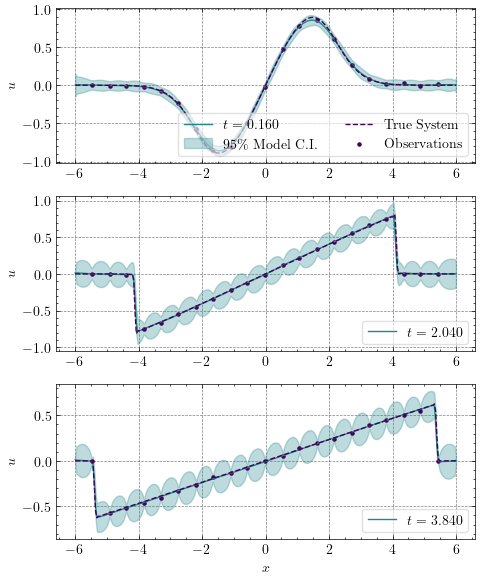

In [97]:
sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]
over_time_sigma_n_estimates = np.repeat(np.mean(sigma_n_estimates, axis=1), np.diff(np.append(truburgvar['temporal_measurement_indices'], burgvar['number_of_steps']+1)))
time_labels = [r"$t=$ "+ f"{burgvar['time_range'][i]:.03f}" for i in range(len(burgvar['time_range']))]

time_index_1 = 8
time_index_2 = 102
time_index_3 = 192

fig, axes = plt.subplots(nrows=3, figsize=(5,6))

axes[0].plot(burgvar['coordinates'],burgvar['u_s'][time_index_1,:], label=time_labels[time_index_1], color=color_list[6])
axes[0].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_1,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])), burgvar['u_s'][time_index_1,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])), alpha=0.3, color=color_list[6], label=r'$95\%$ Model C.I.')
# axes[0].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_1,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])) - 2*over_time_sigma_n_estimates[time_index_1], burgvar['u_s'][time_index_1,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_1])), alpha=0.3, color=color_list[8], label=r'$\pm 2*\hat{\sigma}_n$')
# axes[0].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_1,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])), burgvar['u_s'][time_index_1,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])) + 2*over_time_sigma_n_estimates[time_index_1], alpha=0.3, color=color_list[8])
axes[0].plot(truburgvar['true_coordinates'], truburgvar['u_strue'][time_index_1,:], label='True System', color=color_list[11], linestyle='dashed')
# axes.fill_between(truburgvar['true_coordinates'].flatten(), truburgvar['u_strue'][time_index,:] - 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), truburgvar['u_strue'][time_index,:] + 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')
if time_index_1-1 in truburgvar['temporal_measurement_indices']:
    axes[0].scatter(truburgvar['spatial_measurement_coordinates'], truburgvar['u_observed'][np.where(truburgvar['temporal_measurement_indices'] == time_index_1-1)[0][0],:], color=color_list[11], s=5, label='Observations')
axes[0].set_ylabel(r'$u$')
# axes.set_xlabel(r'$x$')
axes[0].legend(framealpha=0.6, loc='lower right', ncols=2)

axes[1].plot(burgvar['coordinates'],burgvar['u_s'][time_index_2,:], label=time_labels[time_index_2], color=color_list[6])
axes[1].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_2,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])), burgvar['u_s'][time_index_2,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])), alpha=0.3, color=color_list[6])
# axes[1].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_2,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])) - 2*over_time_sigma_n_estimates[time_index_2], burgvar['u_s'][time_index_2,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_2])), alpha=0.3, color=color_list[8])
# axes[1].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_2,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])), burgvar['u_s'][time_index_2,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])) + 2*over_time_sigma_n_estimates[time_index_2], alpha=0.3, color=color_list[8])
axes[1].plot(truburgvar['true_coordinates'], truburgvar['u_strue'][time_index_2,:], color=color_list[11], linestyle='dashed')
# axes.fill_between(truburgvar['true_coordinates'].flatten(), truburgvar['u_strue'][time_index,:] - 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), truburgvar['u_strue'][time_index,:] + 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')
if time_index_2-1 in truburgvar['temporal_measurement_indices']:
    axes[1].scatter(truburgvar['spatial_measurement_coordinates'], truburgvar['u_observed'][np.where(truburgvar['temporal_measurement_indices'] == time_index_2-1)[0][0],:], color=color_list[11], s=5)
axes[1].set_ylabel(r'$u$')
# axes.set_xlabel(r'$x$')
axes[1].legend(framealpha=0.6, loc='lower right')

axes[2].plot(burgvar['coordinates'],burgvar['u_s'][time_index_3,:], label=time_labels[time_index_3], color=color_list[6])
axes[2].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_3,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])), burgvar['u_s'][time_index_3,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])), alpha=0.3, color=color_list[6])
# axes[2].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_3,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])) - 2*over_time_sigma_n_estimates[time_index_3], burgvar['u_s'][time_index_3,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_3])), alpha=0.3, color=color_list[8])
# axes[2].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_3,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])), burgvar['u_s'][time_index_3,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])) + 2*over_time_sigma_n_estimates[time_index_3], alpha=0.3, color=color_list[8])
axes[2].plot(truburgvar['true_coordinates'], truburgvar['u_strue'][time_index_3,:], color=color_list[11], linestyle='dashed')
# axes.fill_between(truburgvar['true_coordinates'].flatten(), truburgvar['u_strue'][time_index,:] - 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), truburgvar['u_strue'][time_index,:] + 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')
if time_index_3-1 in truburgvar['temporal_measurement_indices']:
    axes[2].scatter(truburgvar['spatial_measurement_coordinates'], truburgvar['u_observed'][np.where(truburgvar['temporal_measurement_indices'] == time_index_3-1)[0][0],:], color=color_list[11], s=5)
axes[2].set_ylabel(r'$u$')
axes[2].set_xlabel(r'$x$')
axes[2].legend(framealpha=0.6, loc='lower right')

fig.tight_layout()
plt.show()
plt.close()

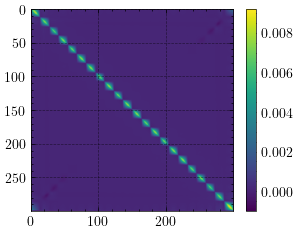

In [90]:
plt.imshow(burgvar['covs'][time_index_3,:,:])
plt.colorbar()

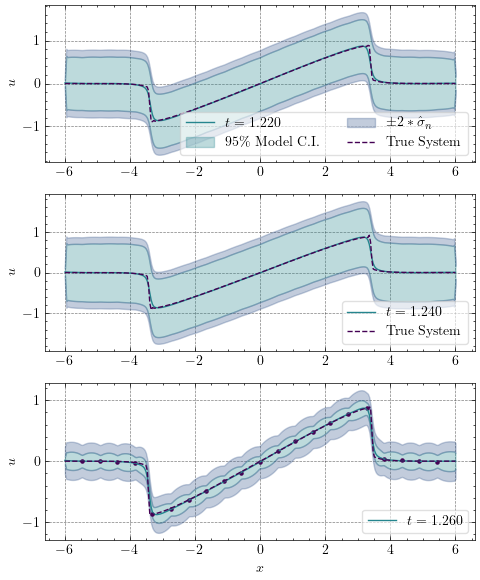

In [82]:
sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]
over_time_sigma_n_estimates = np.repeat(np.mean(sigma_n_estimates, axis=1), np.diff(np.append(truburgvar['temporal_measurement_indices'], burgvar['number_of_steps']+1)))
time_labels = [r"$t=$ "+ f"{burgvar['time_range'][i]:.03f}" for i in range(len(burgvar['time_range']))]

time_index_1 = 61
time_index_2 = 62
time_index_3 = 63

fig, axes = plt.subplots(nrows=3, figsize=(5,6))

axes[0].plot(burgvar['coordinates'],burgvar['u_s'][time_index_1,:], label=time_labels[time_index_1], color=color_list[6])
axes[0].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_1,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])), burgvar['u_s'][time_index_1,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])), alpha=0.3, color=color_list[6], label=r'$95\%$ Model C.I.')
axes[0].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_1,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])) - 2*over_time_sigma_n_estimates[time_index_1], burgvar['u_s'][time_index_1,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_1])), alpha=0.3, color=color_list[8], label=r'$\pm 2*\hat{\sigma}_n$')
axes[0].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_1,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])), burgvar['u_s'][time_index_1,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_1,:,:])) + 2*over_time_sigma_n_estimates[time_index_1], alpha=0.3, color=color_list[8])
axes[0].plot(truburgvar['true_coordinates'], truburgvar['u_strue'][time_index_1,:], label='True System', color=color_list[11], linestyle='dashed')
# axes.fill_between(truburgvar['true_coordinates'].flatten(), truburgvar['u_strue'][time_index,:] - 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), truburgvar['u_strue'][time_index,:] + 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')
if time_index_1-1 in truburgvar['temporal_measurement_indices']:
    axes[0].scatter(truburgvar['spatial_measurement_coordinates'], truburgvar['u_observed'][np.where(truburgvar['temporal_measurement_indices'] == time_index_1-1)[0][0],:], color=color_list[11], s=5, label='Observations')
axes[0].set_ylabel(r'$u$')
# axes.set_xlabel(r'$x$')
axes[0].legend(framealpha=0.6, loc='lower right', ncols=2)

axes[1].plot(burgvar['coordinates'],burgvar['u_s'][time_index_2,:], label=time_labels[time_index_2], color=color_list[6])
axes[1].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_2,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])), burgvar['u_s'][time_index_2,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])), alpha=0.3, color=color_list[6])
axes[1].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_2,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])) - 2*over_time_sigma_n_estimates[time_index_2], burgvar['u_s'][time_index_2,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_2])), alpha=0.3, color=color_list[8])
axes[1].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_2,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])), burgvar['u_s'][time_index_2,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_2,:,:])) + 2*over_time_sigma_n_estimates[time_index_2], alpha=0.3, color=color_list[8])
axes[1].plot(truburgvar['true_coordinates'], truburgvar['u_strue'][time_index_2,:], label='True System', color=color_list[11], linestyle='dashed')
# axes.fill_between(truburgvar['true_coordinates'].flatten(), truburgvar['u_strue'][time_index,:] - 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), truburgvar['u_strue'][time_index,:] + 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')
if time_index_2-1 in truburgvar['temporal_measurement_indices']:
    axes[1].scatter(truburgvar['spatial_measurement_coordinates'], truburgvar['u_observed'][np.where(truburgvar['temporal_measurement_indices'] == time_index_2-1)[0][0],:], color=color_list[11], s=5)
axes[1].set_ylabel(r'$u$')
# axes.set_xlabel(r'$x$')
axes[1].legend(framealpha=0.6, loc='lower right')

axes[2].plot(burgvar['coordinates'],burgvar['u_s'][time_index_3,:], label=time_labels[time_index_3], color=color_list[6])
axes[2].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_3,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])), burgvar['u_s'][time_index_3,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])), alpha=0.3, color=color_list[6])
axes[2].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_3,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])) - 2*over_time_sigma_n_estimates[time_index_3], burgvar['u_s'][time_index_3,:] - 2*np.sqrt(np.diag(burgvar['covs'][time_index_3])), alpha=0.3, color=color_list[8])
axes[2].fill_between(burgvar['coordinates'].flatten(), burgvar['u_s'][time_index_3,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])), burgvar['u_s'][time_index_3,:] + 2*np.sqrt(np.diag(burgvar['covs'][time_index_3,:,:])) + 2*over_time_sigma_n_estimates[time_index_3], alpha=0.3, color=color_list[8])
axes[2].plot(truburgvar['true_coordinates'], truburgvar['u_strue'][time_index_3,:], color=color_list[11], linestyle='dashed')
# axes.fill_between(truburgvar['true_coordinates'].flatten(), truburgvar['u_strue'][time_index,:] - 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), truburgvar['u_strue'][time_index,:] + 2*truburgvar['sigma_n_true']*np.ones(len(truburgvar['true_coordinates'])), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')
if time_index_3-1 in truburgvar['temporal_measurement_indices']:
    axes[2].scatter(truburgvar['spatial_measurement_coordinates'], truburgvar['u_observed'][np.where(truburgvar['temporal_measurement_indices'] == time_index_3-1)[0][0],:], color=color_list[11], s=5)
axes[2].set_ylabel(r'$u$')
axes[2].set_xlabel(r'$x$')
axes[2].legend(framealpha=0.6, loc='lower right')

fig.tight_layout()
plt.show()
plt.close()

In [35]:
len(over_time_sigma_n_estimates)

198

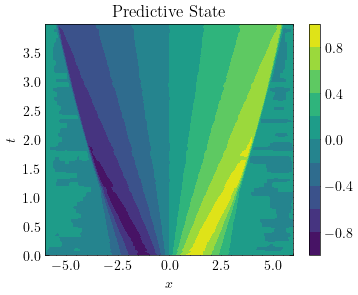

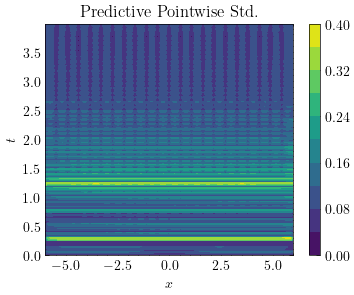

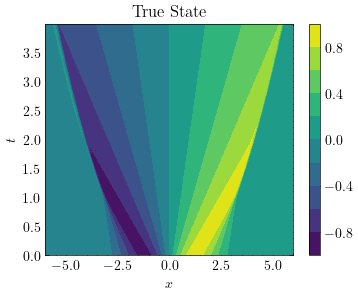

In [50]:
fig, axes = plt.subplots(figsize=(4,3))
plot = axes.contourf(burgvar['coordinates'].flatten(), burgvar['time_range'], burgvar['u_s'], levels=contour_levels)
# num = 0
# for coord in spatial_measurement_coordinates.flatten():
#     if num == 0:
#         axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
#     else:
#         axes.axvline(coord, linestyle='--', color='black')
#     num += 1
# num = 0
# for coord in temporal_measurement_coordinates.flatten():
#     if num == 0:
#         axes.axhline(coord, linestyle='--', color='black')
#     else:
#         axes.axhline(coord, linestyle='--', color='black')
#     num += 1

# x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
# x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('Predictive State')
fig.colorbar(plot)
# plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(4,3))
plot = axes.contourf(burgvar['coordinates'].flatten(), burgvar['time_range'], np.sqrt(np.diagonal(burgvar['covs'], axis1=1, axis2=2)), levels=contour_levels)
# num = 0
# for coord in spatial_measurement_coordinates.flatten():
#     if num == 0:
#         axes.axvline(coord, linestyle='--', label='Measurement Times and Locations', color='black')
#     else:
#         axes.axvline(coord, linestyle='--', color='black')
#     num += 1
# num = 0
# for coord in temporal_measurement_coordinates.flatten():
#     if num == 0:
#         axes.axhline(coord, linestyle='--', color='black')
#     else:
#         axes.axhline(coord, linestyle='--', color='black')
#     num += 1

# x_temp, y_temp = np.meshgrid(true_coordinates[spatial_measurement_indices].flatten(), time_range[temporal_measurement_indices].flatten())
# x_temp, y_temp = x_temp.flatten(), y_temp.flatten()

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
axes.set_title('Predictive Pointwise Std.')
fig.colorbar(plot)
# plt.legend()
plt.show()

fig, axes = plt.subplots(figsize=(4,3))
# plot = axes.contourf(spatial_measurement_coordinates.flatten(), temporal_measurement_coordinates, u_observed, levels=contour_levels+50)
plot = axes.contourf(truburgvar['true_coordinates'].flatten(), burgvar['time_range'], truburgvar['u_strue'], levels=contour_levels)
axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$t$')
# axes.set_title('Observed Model State')
axes.set_title('True State')
fig.colorbar(plot)
# plt.legend()
plt.show()

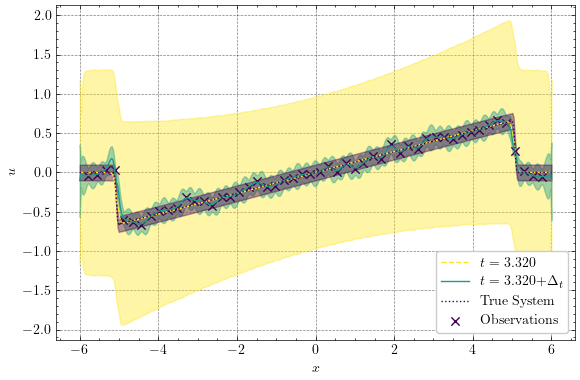

In [58]:
interest = 1
time_labels = [r"$t=$ "+f"{temporal_measurement_coordinates[i]:.03f}" for i in range(len(temporal_measurement_coordinates))]
plot_ind = temporal_measurement_indices[interest]

fig, axes = plt.subplots(figsize=(6,4))

axes.plot(coordinates,u_s[plot_ind,:], label=time_labels[interest], color=color_list[0], linestyle='dashed')
axes.fill_between(coordinates.flatten(), u_s[plot_ind,:] - 2*np.sqrt(np.diag(covs[plot_ind,:,:])), u_s[plot_ind,:] + 2*np.sqrt(np.diag(covs[plot_ind,:,:])), alpha=0.4, color=color_list[0])

axes.plot(coordinates,u_s[plot_ind + 1,:], label=time_labels[interest] + r'$+ \Delta_t$', color=color_list[5])
axes.fill_between(coordinates.flatten(), u_s[plot_ind+1,:] - 2*np.sqrt(np.diag(covs[plot_ind+1,:,:])), u_s[plot_ind+1,:] + 2*np.sqrt(np.diag(covs[plot_ind+1,:,:])), alpha=0.4, color=color_list[5])

axes.plot(true_coordinates, u_strue[plot_ind+1,:], label='True System', color=color_list[11], linestyle='dotted')
axes.scatter(spatial_measurement_coordinates, u_observed[interest,:], label='Observations', marker='x', color=color_list[11])
axes.fill_between(true_coordinates.flatten(), u_strue[plot_ind+1,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[plot_ind+1,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower right')
fig.tight_layout()
plt.show()

In [101]:
time_labels = [r"$t=$ "+str(round(time_range[i],3)) for i in range(len(time_range))]

for time_index in tqdm(range(len(time_range))):
    filename = r"burger_pics/image" + str(time_index) + ".png"

    # fig, axes = plt.subplots(figsize=(6,5))

    # axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[5])
    # axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[5])

    # axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted')
    # axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

    # axes.set_xlabel(r'$x$')
    # axes.set_ylabel(r'$u$')

    # axes.set_ylim(-1.5, 1.5)

    # axes.legend(loc='lower center')
    # fig.tight_layout()

    fig, axes = plt.subplots(figsize=(6,4))

    axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[6], linewidth=2.)
    axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[6], label=r'$95\%$ Model C.I.')
    # axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*np.mean(sigma_n_estimates[-1]), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[5], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
    # axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*np.mean(sigma_n_estimates[-1]), alpha=0.3, color=color_list[5], hatch=r"\ ")

    axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted', linewidth=2.)
    # axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')

    axes.set_xlabel(r'$x$')
    axes.set_ylabel(r'$u$')
    axes.set_ylim(-1.1, 1.1)

    axes.legend(loc='lower right')
    fig.tight_layout()
    plt.savefig(filename)
    plt.close()

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▎         | 5/200 [00:01<01:13,  2.64it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7861dbf885f0>>
Traceback (most recent call last):
  File "/home/daniel/anaconda3/envs/pymcenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
100%|██████████| 200/200 [01:10<00:00,  2.85it/s]


In [124]:
time_labels = [r"$t=$ "+str(round(time_range[i],3)) for i in range(len(time_range))]

for time_index in tqdm(range(len(time_range))):
    filename = r"burger_pics/image" + str(time_index) + ".png"

    # fig, axes = plt.subplots(figsize=(6,5))

    # axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[5])
    # axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[5])

    # axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted')
    # axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.4, color=color_list[11])

    # axes.set_xlabel(r'$x$')
    # axes.set_ylabel(r'$u$')

    # axes.set_ylim(-1.5, 1.5)

    # axes.legend(loc='lower center')
    # fig.tight_layout()

    fig, axes = plt.subplots(figsize=(6,4))

    axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[6], linewidth=2.)
    axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[6], label=r'$95\%$ Model C.I.')
    # axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*np.mean(sigma_n_estimates[-1]), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[5], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
    # axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*np.mean(sigma_n_estimates[-1]), alpha=0.3, color=color_list[5], hatch=r"\ ")

    axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted', linewidth=2.)
    # axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')

    mesind = 0
    for xlineco in truburgvar['spatial_measurement_coordinates']:
        if mesind == 0:
            axes.axvline(xlineco, linewidth=0.5, color='black', linestyle='dashed', label='Obs. Locations')
        else:
            axes.axvline(xlineco, linewidth=1.5, color='black', linestyle='dashed')
        mesind += 1

    axes.set_xlabel(r'$x$')
    axes.set_ylabel(r'$u$')
    axes.set_ylim(-1.1, 1.1)

    axes.legend(loc='lower right')
    fig.tight_layout()
    plt.savefig(filename)
    plt.close()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:10<00:00,  2.84it/s]


/tmp/ipykernel_4035042/861648435.py:9: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*np.mean(sigma_n_estimates[-1]), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[5], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
/tmp/ipykernel_4035042/861648435.py:10: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*np.mean(sigma_n_estimates[-1]), alpha=0.3, colo

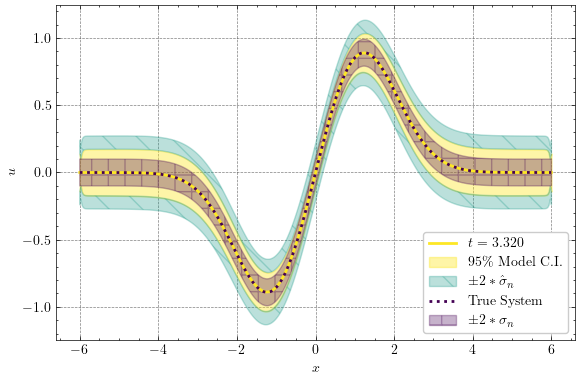

In [62]:
time_index = 1

fig, axes = plt.subplots(figsize=(6,4))

axes.plot(coordinates,u_s[time_index,:], label=time_labels[time_index], color=color_list[0], linewidth=2.)
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.4, color=color_list[0], label=r'$95\%$ Model C.I.')
axes.fill_between(coordinates.flatten(), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])) - 2*np.mean(sigma_n_estimates[-1]), u_s[time_index,:] - 2*np.sqrt(np.diag(covs[time_index,:,:])), alpha=0.3, color=color_list[5], label=r'$\pm 2*\hat{\sigma}_n$', hatch=r"\ ")
axes.fill_between(coordinates.flatten(), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])), u_s[time_index,:] + 2*np.sqrt(np.diag(covs[time_index,:,:])) + 2*np.mean(sigma_n_estimates[-1]), alpha=0.3, color=color_list[5], hatch=r"\ ")

axes.plot(true_coordinates, u_strue[time_index,:], label='True System', color=color_list[11], linestyle='dotted', linewidth=2.)
axes.fill_between(true_coordinates.flatten(), u_strue[time_index,:] - 2*sigma_n_true*np.ones(len(true_coordinates)), u_strue[time_index,:] + 2*sigma_n_true*np.ones(len(true_coordinates)), alpha=0.3, color=color_list[11], hatch='+', label=r'$\pm 2*\sigma_n$')

axes.set_xlabel(r'$x$')
axes.set_ylabel(r'$u$')

axes.legend(loc='lower right')
fig.tight_layout()

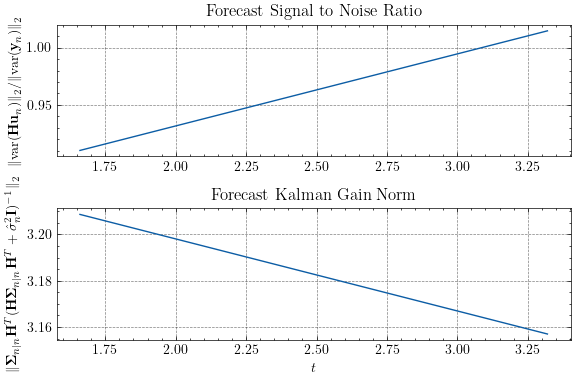

In [63]:
fig, axes = plt.subplots(nrows=2, figsize=(6,4))

sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]

axes[0].plot(temporal_measurement_coordinates, [np.abs(np.var(observation_operator @ u_s[temporal_measurement_indices[i],:])) / np.abs(np.var(u_observed[i,:])) for i in range(temporal_points)])
axes[0].set_title('Forecast Signal to Noise Ratio')
axes[0].set_ylabel(r'$\Vert \text{var} (\mathbf{Hu}_n) \Vert_2 / \Vert \text{var}(\mathbf{y}_n)\Vert_2$')

axes[1].plot(temporal_measurement_coordinates,[np.linalg.svd(covs[temporal_measurement_indices[i]] @ observation_operator.T @ np.linalg.inv(observation_operator @ covs[temporal_measurement_indices[i]] @ observation_operator.T + ((np.mean(sigma_n_estimates[i]))**2)*np.eye(spatial_points))).S[0] for i in range(temporal_points)])
axes[1].set_title('Forecast Kalman Gain Norm')
axes[1].set_ylabel(r'$\Vert \mathbf{\Sigma}_{n|n} \mathbf{H}^T(\mathbf{H}\mathbf{\Sigma}_{n|n}\mathbf{H}^T + \hat{\sigma}^2_n\mathbf{I})^{-1}\Vert_2$')
axes[1].set_xlabel(r'$t$')

fig.tight_layout()

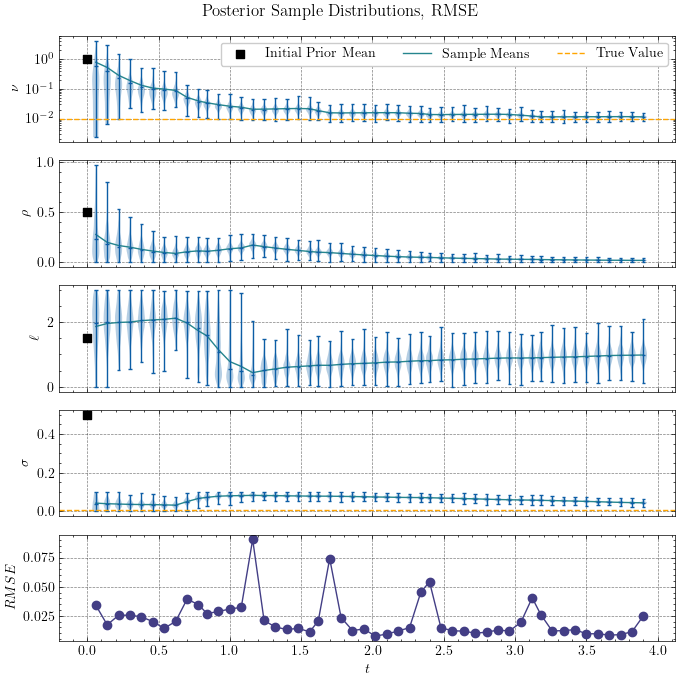

In [99]:
nu_estimates = [10**traces[i].posterior['nu'].data.flatten() for i in range(len(traces))]
rho_estimates = [traces[i].posterior['rho'].data.flatten() for i in range(len(traces))]
ell_estimates = [traces[i].posterior['ell'].data.flatten() for i in range(len(traces))]
sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]

rms_obs = np.sqrt(np.mean((np.asarray([burgvar['observation_operator'] @ burgvar['u_s'][i,:] for i in temporal_measurement_indices]) - np.asarray([u_observed[i,:] for i in range(temporal_points)]))**2, axis=1))
# rms_true = np.sqrt(np.mean((u_s - u_strue)**2, axis=1))
plot_time_coords = truburgvar['temporal_measurement_coordinates']

fig, axs = plt.subplots(5, 1, figsize=(7,7), sharex=True)

axs[0].set_yscale("log")
axs[0].scatter(0, 10**(burgvar['nu_params'][2]), marker='s', color='black', label='Initial Prior Mean')
axs[0].plot(plot_time_coords, [(np.mean(trace_set)) for trace_set in nu_estimates], label='Sample Means', color=color_list[6])#, linestyle='dashed')
# axs[0].fill_between(plot_time_coords, [(np.mean(trace_set) - 2*np.std(trace_set)) for trace_set in alpha_estimates], [(np.mean(trace_set) + 2*np.std(trace_set)) for trace_set in alpha_estimates], color=color_list[6], alpha=0.1, label=r'$\pm 2\hat{\sigma}$')
axs[0].violinplot(dataset=nu_estimates, positions=plot_time_coords, showmedians=True, widths=0.05)
#axs[0].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in nu_estimates], marker='x', color='black', label='Sample Means')
#axs[0].set_ylim((10**nu_params[0],10**nu_params[1]))
axs[0].axhline(true_nu, color='orange', linestyle='dashed', label='True Value')
axs[0].legend(loc='upper right', ncols=3)
axs[0].set_ylabel(r'$\nu$')

axs[1].scatter(0, burgvar['rho_params'][2], marker='s', color='black', label='Initial Prior Mean')
axs[1].plot(plot_time_coords, [np.mean(trace_set) for trace_set in rho_estimates], label='Rho Estimates', color=color_list[6])#, linestyle='dashed')
# axs[2].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in rho_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in rho_estimates], color=color_list[6], alpha=0.1)
#axs[1].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in rho_estimates], marker='x', color='black')
axs[1].violinplot(dataset=rho_estimates, positions=plot_time_coords, showmedians=True, widths=0.05)
axs[1].set_ylabel(r'$\rho$')

axs[2].scatter(0, burgvar['ell_params'][2], marker='s', color='black', label='Initial Prior Mean')
axs[2].plot(plot_time_coords,[np.mean(trace_set) for trace_set in ell_estimates], label='Ell Estimates', color=color_list[6])#, linestyle='dashed')
# axs[3].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in ell_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in ell_estimates], color=color_list[6], alpha=0.1)
#axs[2].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in ell_estimates], marker='x', color='black')
axs[2].violinplot(dataset=ell_estimates, positions=plot_time_coords, showmedians=True, widths=0.05)
axs[2].set_ylabel(r'$\ell$')

axs[3].scatter(0, burgvar['sigma_n_params'][2], marker='s', color='black', label='Initial Prior Mean')
axs[3].plot(plot_time_coords, [np.mean(trace_set) for trace_set in sigma_n_estimates], label='Sigma_n Estimates', color=color_list[6])#, linestyle='dashed')
# axs[4].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in sigma_n_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in sigma_n_estimates], color=color_list[6], alpha=0.1)
#axs[3].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in sigma_n_estimates], marker='x', color='black')
axs[3].violinplot(dataset=sigma_n_estimates, positions=plot_time_coords, showmedians=True, widths=0.05)
axs[3].axhline(sigma_n_true, color='orange', linestyle='dashed')
axs[3].set_ylabel(r'$\sigma$')

# axs[5].plot(time_range, rms_true, label='True RMS Error', color=color_list[6])
axs[4].scatter(temporal_measurement_coordinates, rms_obs, label='Obs. RMS Error', color=color_list[9])
axs[4].plot(temporal_measurement_coordinates, rms_obs, label='Obs. RMS Error', color=color_list[9])
axs[4].set_ylabel(r'$RMSE$')
axs[4].set_xlabel(r'$t$')

fig.suptitle('Posterior Sample Distributions, RMSE')
fig.tight_layout()
# Adjust layout
#plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()
plt.close()

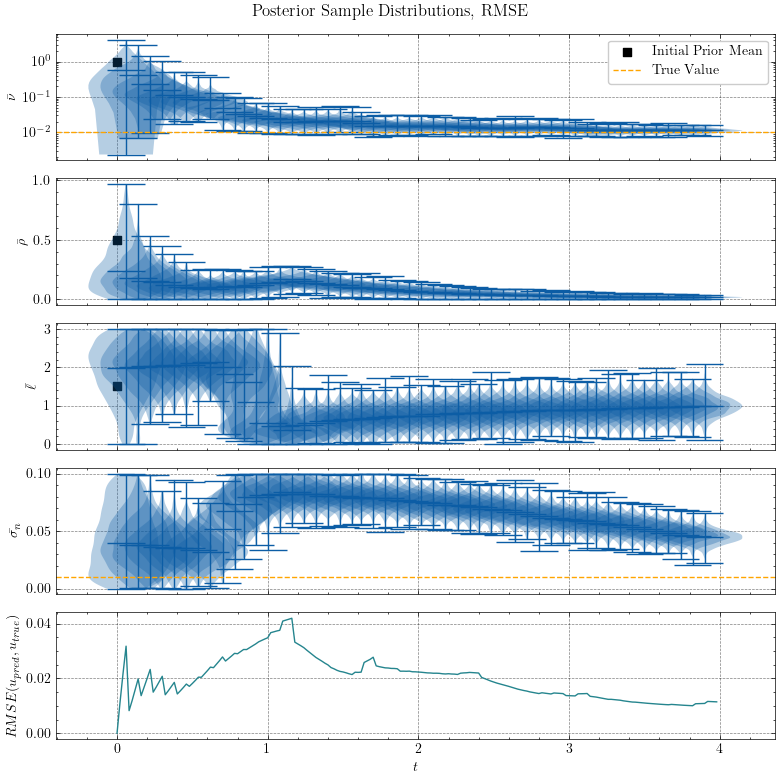

In [39]:
#nu_estimates = [np.mean(traces[i].posterior['nu'].data.flatten()) for i in range(len(traces))]
# rho_estimates = [np.mean(traces[i].posterior['rho'].data.flatten()) for i in range(len(traces))]
# ell_estimates = [np.mean(traces[i].posterior['ell'].data.flatten()) for i in range(len(traces))]
# sigma_n_estimates = [np.mean(traces[i].posterior['sigma_n'].data.flatten()) for i in range(len(traces))]

nu_estimates = [10**traces[i].posterior['nu'].data.flatten() for i in range(len(traces))]
rho_estimates = [traces[i].posterior['rho'].data.flatten() for i in range(len(traces))]
ell_estimates = [traces[i].posterior['ell'].data.flatten() for i in range(len(traces))]
sigma_n_estimates = [traces[i].posterior['sigma_n'].data.flatten() for i in range(len(traces))]

rms = np.sqrt(np.mean((u_s - u_strue)**2, axis=1))
plot_time_coords = temporal_measurement_coordinates

fig, axs = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

axs[0].set_yscale("log")
# nu_mins = [np.min(data) for data in nu_estimates]
# nu_maxs = [np.max(data) for data in nu_estimates]
# nu_meds = [np.median(data) for data in nu_estimates]
# nu_q1 = [np.quantile(data, 0.25) for data in nu_estimates]
# nu_q3 = [np.quantile(data, 0.75) for data in nu_estimates]
# axs[0].plot(plot_time_coords, nu_mins, color=color_list[6], linestyle='dotted')
# axs[0].plot(plot_time_coords, nu_q1, color=color_list[6], linestyle='dashed')
# axs[0].plot(plot_time_coords, nu_meds, color=color_list[6])
# axs[0].plot(plot_time_coords, nu_q3, color=color_list[6], linestyle='dashed')
# axs[0].plot(plot_time_coords, nu_maxs, color=color_list[6], linestyle='dotted')
axs[0].scatter(0, 10**(nu_params[2]), marker='s', color='black', label='Initial Prior Mean')
# axs[0].plot(plot_time_coords, [10**(np.mean(trace_set)) for trace_set in nu_estimates], label='Sample Means', color=color_list[6])#, linestyle='dashed')
# axs[0].fill_between(plot_time_coords, [10**(np.mean(trace_set) - 2*np.std(trace_set)) for trace_set in nu_estimates], [10**(np.mean(trace_set) + 2*np.std(trace_set)) for trace_set in nu_estimates], color=color_list[6], alpha=0.1, label=r'$\pm 2\hat{\sigma}$')
axs[0].violinplot(dataset=nu_estimates, positions=plot_time_coords, showmedians=True)
# axs[0].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in nu_estimates], marker='x', color='black', label='Sample Means')
# axs[0].set_ylim((10**nu_params[0],10**nu_params[1]))

axs[0].axhline(true_nu, color='orange', linestyle='dashed', label='True Value')
axs[0].legend(loc='upper right', ncols=1)
axs[0].set_ylabel(r'$\bar{\nu}$')

axs[1].scatter(0, rho_params[2], marker='s', color='black', label='Initial Prior Mean')
# axs[1].plot(plot_time_coords, [np.mean(trace_set) for trace_set in rho_estimates], label='Rho Estimates', color=color_list[6])#, linestyle='dashed')
# axs[1].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in rho_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in rho_estimates], color=color_list[6], alpha=0.1)
#axs[1].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in rho_estimates], marker='x', color='black')
axs[1].violinplot(dataset=rho_estimates, positions=plot_time_coords, showmedians=True)
axs[1].set_ylabel(r'$\bar{\rho}$')

axs[2].scatter(0, ell_params[2], marker='s', color='black', label='Initial Prior Mean')
# axs[2].plot(plot_time_coords,[np.mean(trace_set) for trace_set in ell_estimates], label='Ell Estimates', color=color_list[6])#, linestyle='dashed')
# axs[2].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in ell_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in ell_estimates], color=color_list[6], alpha=0.1)
#axs[2].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in ell_estimates], marker='x', color='black')
axs[2].violinplot(dataset=ell_estimates, positions=plot_time_coords, showmedians=True)
axs[2].set_ylabel(r'$\bar{\ell}$')

#axs[3].scatter(0, sigma_n_params[2], marker='s', color='black', label='Initial Prior Mean')
# axs[3].plot(plot_time_coords, [np.mean(trace_set) for trace_set in sigma_n_estimates], label='Sigma_n Estimates', color=color_list[6])#, linestyle='dashed')
# axs[3].fill_between(plot_time_coords, [np.mean(trace_set) - 2*np.std(trace_set) for trace_set in sigma_n_estimates], [np.mean(trace_set) + 2*np.std(trace_set) for trace_set in sigma_n_estimates], color=color_list[6], alpha=0.1)
#axs[3].scatter(plot_time_coords, [np.mean(trace_set) for trace_set in sigma_n_estimates], marker='x', color='black')
axs[3].violinplot(dataset=sigma_n_estimates, positions=plot_time_coords, showmedians=True)
axs[3].axhline(sigma_n_true, color='orange', linestyle='dashed')
axs[3].set_ylabel(r'$\bar{\sigma_n}$')

axs[4].plot(time_range, rms, label='RMS Error', color=color_list[6])
axs[4].set_ylabel(r'$RMSE(u_{pred}, u_{true})$')
axs[4].set_xlabel(r'$t$')

fig.suptitle('Posterior Sample Distributions, RMSE')
fig.tight_layout()
# Adjust layout
#plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()
plt.close()

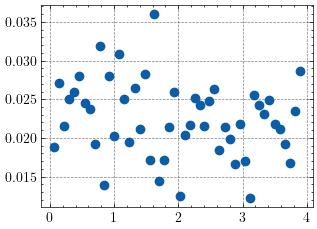

In [115]:
plt.scatter(temporal_measurement_coordinates,[np.max(np.abs(observation_operator @ truburgvar['u_strue'][temporal_measurement_indices[i],:] - truburgvar['u_observed'][i,:])) for i in range(temporal_points)])